In [6]:
from scipy.integrate import solve_ivp
import numpy as np
import qpsolvers
from scipy.linalg import block_diag
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt

## Example: Single Pendulum

$$ 
\begin{align*}
\mathbb{L} &= T - V \\
&= \frac{1}{2}ml^2\dot{\theta}^2 + mgl \cos{\theta}
\end{align*}$$

which can be used below to give the 2nd ode that governs the dynamics of the system.

$$ 
\begin{align*}
&\frac{d}{dt} \left(  \frac{\partial L}{\partial \dot{\theta}}  \right) -  \frac{\partial L}{\partial \theta} = 0 \\
\implies & ml^2 \ddot{\theta} + mgl \sin{\theta} = 0
\end{align*}$$

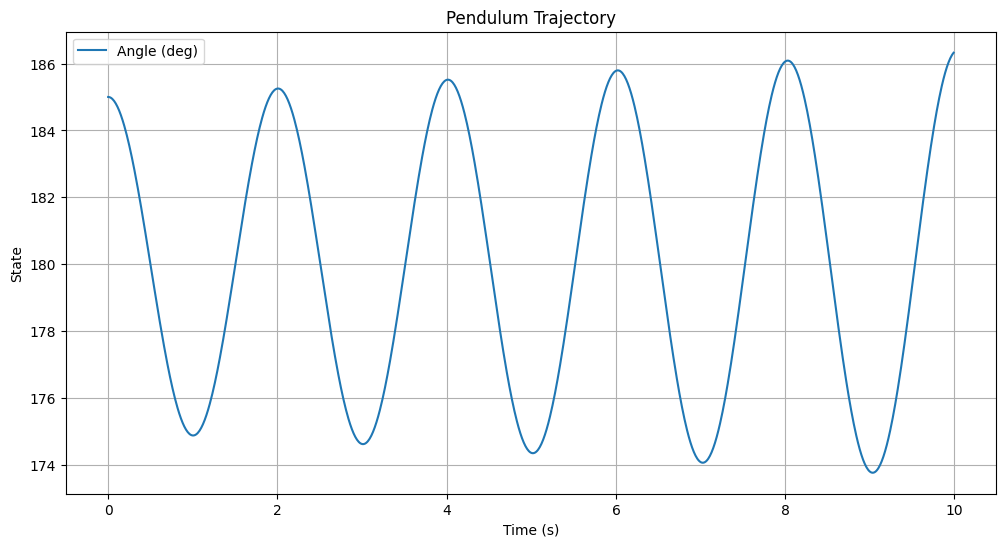

In [7]:
def pendulum_dynamics(x, u, length=1.0, g=9.81, dt=0.01):
    theta, theta_dot = x
    theta_ddot = (g / length) * np.sin(theta) + u / (length**2)
    theta_dot_new = theta_dot + theta_ddot * dt
    theta_new = theta + theta_dot * dt + 0.5 * theta_ddot * dt**2
    return np.array([theta_new, theta_dot_new])


def linearize_pendulum_dynamics(length=1.0, g=9.81, dt=0.01):
    A_cont = np.array([[0, 1], [-g / length, 0]])
    B_cont = np.array([[0], [1 / (length**2)]])

    # Discretize using Euler method
    A_disc = np.eye(2) + A_cont * dt
    B_disc = B_cont * dt
    return A_disc, B_disc


# Simulate pendulum trajectory
theta_start = np.deg2rad(185)  # Convert 5 degrees to radians
x_start = np.array([theta_start, 0])  # Initial state: [theta, theta_dot]
time = 10  # Number of simulation steps
dt = 0.01  # Time step
steps = int(time / dt)
trajectory = np.zeros((steps, 2))
trajectory[0] = x_start

for i in range(1, steps):
    u = 0  # 0.5 * np.sin(i * dt)
    trajectory[i] = pendulum_dynamics(
        trajectory[i - 1], u, dt=dt
    )  # No control input (u=0)

# Plot the pendulum trajectory
time = np.arange(steps) * dt  # Time array in seconds
plt.figure(figsize=(12, 6))
plt.plot(time, np.rad2deg(trajectory[:, 0]), label="Angle (deg)")
plt.title("Pendulum Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.legend()
plt.grid(True)
plt.show()

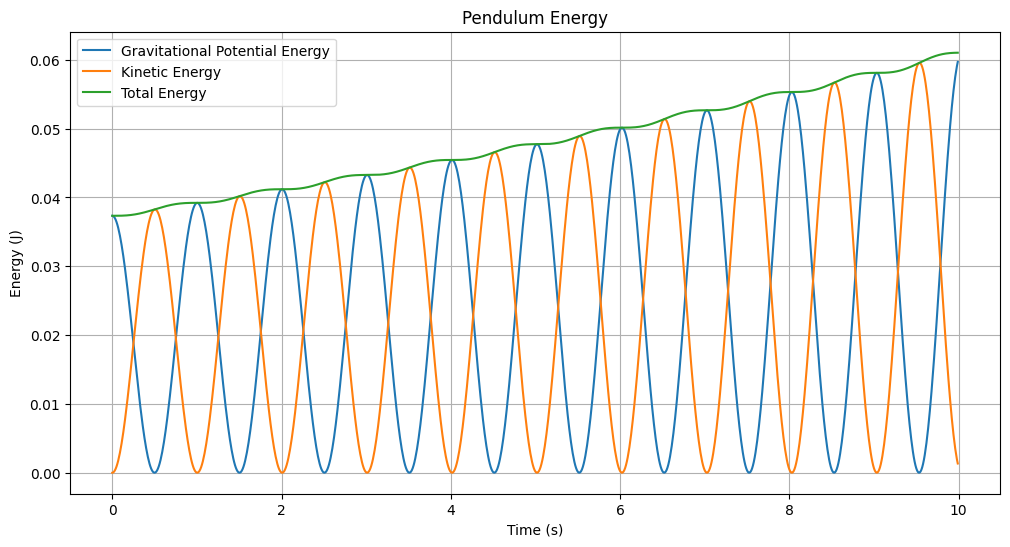

In [8]:
gp = 1 * 9.81 * (1 + np.cos(trajectory[:, 0]))

ke = 0.5 * 1 * trajectory[:, 1] ** 2

total_energy = gp + ke

# Plot the total energy of the pendulum
plt.figure(figsize=(12, 6))
plt.plot(time, gp, label="Gravitational Potential Energy")
plt.plot(time, ke, label="Kinetic Energy")
plt.plot(time, total_energy, label="Total Energy")
plt.title("Pendulum Energy")
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.legend()
plt.grid(True)
plt.show()

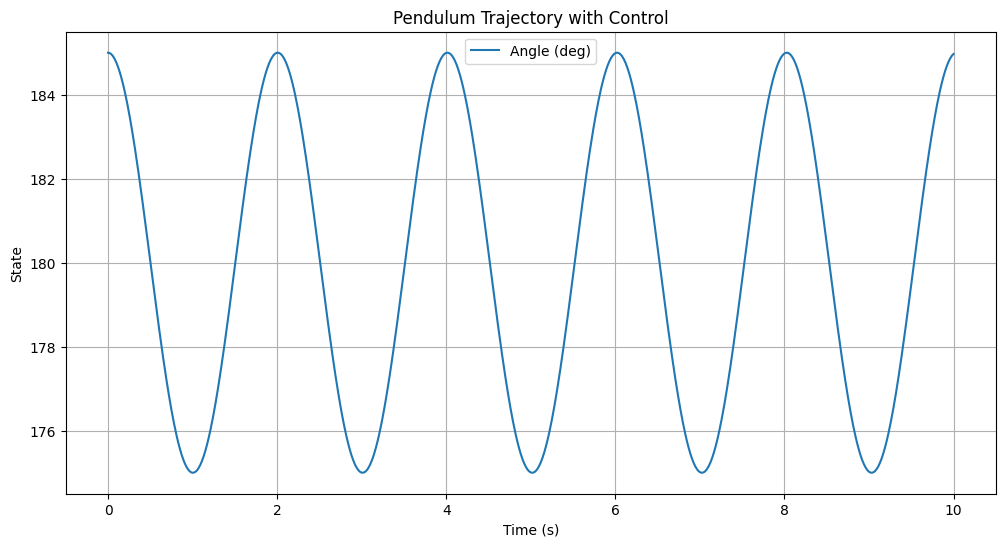

In [9]:
# Define the pendulum dynamics as an ODE with control input
def pendulum_ode(t, y, u, length=1.0, g=9.81):
    theta, theta_dot = y
    theta_ddot = (g / length) * np.sin(theta) + u / (length**2)
    return [theta_dot, theta_ddot]


# Initial conditions
theta_start = np.deg2rad(185)  # Convert 185 degrees to radians
x_start = [theta_start, 0]  # Initial state: [theta, theta_dot]

# Time span for the simulation
t_span = (0, 10)  # 10 seconds
dt = 0.01
t_eval = np.arange(
    t_span[0], t_span[1] + dt, dt
)  # Time points where solution is computed

# Define the control input as an array matching the time/dt
control_input = np.zeros_like(
    0.5 * np.sin(t_eval)
)  # Example control input, can be replaced with actual control input


# Solve the ODE with control input step by step
def solve_pendulum_with_control_step_by_step(t_span, x_start, t_eval, control_input):
    y = np.zeros((len(t_eval), len(x_start)))
    y[0] = x_start
    for i in range(1, len(t_eval)):
        t = t_eval[i - 1 : i + 1]
        u = control_input[i - 1]
        sol = solve_ivp(pendulum_ode, (t[0], t[1]), y[i - 1], args=(u,), t_eval=t)
        y[i] = sol.y[:, -1]
    return t_eval, y


t_eval, solution = solve_pendulum_with_control_step_by_step(
    t_span, x_start, t_eval, control_input
)

# Extract the solution
theta = solution[:, 0]
theta_dot = solution[:, 1]

# Plot the pendulum trajectory
plt.figure(figsize=(12, 6))
plt.plot(t_eval, np.rad2deg(theta), label="Angle (deg)")
plt.title("Pendulum Trajectory with Control")
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.legend()
plt.grid(True)
plt.show()

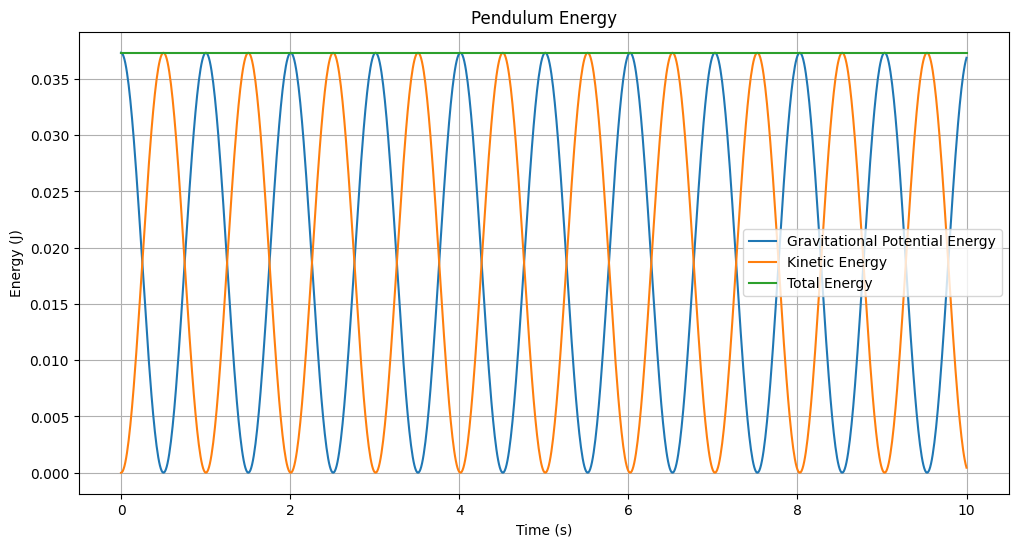

In [10]:
gp = 1 * 9.81 * (1 + np.cos(theta))

ke = 0.5 * 1 * theta_dot**2

total_energy = gp + ke

# Plot the total energy of the pendulum
plt.figure(figsize=(12, 6))
plt.plot(t_eval, gp, label="Gravitational Potential Energy")
plt.plot(t_eval, ke, label="Kinetic Energy")
plt.plot(t_eval, total_energy, label="Total Energy")
plt.title("Pendulum Energy")
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.legend()
plt.grid(True)
plt.show()